# Chile Ocean Acidification data access from CEAZAMET and its web services

Developed by Emilio Mayorga ([https://github.com/emiliom](https://github.com/emiliom)) for data ingest into the [GOA-ON Data Portal](http://portal.goa-on.org/).

- Last tested on 2020-September-8
- Work started in 2017-October

**NOTES:**

- Web service request uses the robust web service at http://www.ceazamet.cl/ws/pop_ws_doc.php. For ingest into the GOA-ON Data Portal, we registered a NANOOS email address with CeazaMet.
- Useful `p_cod` (codigo proveedor?) include `ceazamet` and `cdom`
- `e_cod` = codigo de estacion; `s_cod` = codigo de sensor (parametro)
- It would be convenient to be able to request multiple variables at the same time, but the capability apparently is not available
- Datetime filters are limited to a *daily* resolution, not hourly
- Is `ultima_lectura` the end of the interval, the midpoint, or the start?
- Time is in "GMT-4 fixed". Convert to UTC datetime type
- Note: If `fecha_fin` is past the latest data, the `GetSerieSensor` request fails, and it's misleading, b/c it makes a reference to `fecha_inicio`
- No-Data flag: `GetSerieSensor` flag for no-data, once read into DataFrame, is an np.nan that can be tested with `np.isnan()`. eg, `np.isnan(df3['prom'].iloc[0])`. BUT, a specific flag value can also be requested via the argument `valor_nan`

In [1]:
%matplotlib inline
from io import BytesIO
# For Python 2.7: from StringIO import StringIO
import requests
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def ceazamet_request(fn, p_cod='cdom', extra_params=None):
    nanoos_cred = 'ENTER EMAIL ADDRESS REGISTERED WITH CEAZAMET'

    # Sample request, requiring no email registration:
    # http://www.ceazamet.cl/ws/pop_ws.php?fn=GetListaEstaciones&p_cod=ceazamet&user=anon@nohost.com
    params = {
        'user': nanoos_cred,
        'fn': fn,
        'p_cod': p_cod
    }
    if extra_params:
        params.update(extra_params)
    
    req = requests.get(
        'http://www.ceazamet.cl/ws/pop_ws.php', 
        params=params
    )

    # Use this code to examine the raw response
    # respln = req.content.splitlines()
    # respln[:10]
    
    df = pd.read_csv(BytesIO(req.content), header=4)
    # For Python 2.7, use StringIO(req.content) instead of BytesIO(req.content)
    
    # Remove "#" prefix from name of first column
    df.rename(columns={df.columns[0]: df.columns[0][1:]}, inplace=True)

    if fn == 'GetSerieSensor':
        # Time is in "GMT-4 fixed". Convert to UTC datetime type
        df.loc[:, 'dt_utc'] = pd.to_datetime(df['ultima_lectura'], utc=True, errors='coerce')
        df.loc[:, 'dt_utc'] = df['dt_utc'] + pd.Timedelta(hours=4)
        df.set_index('dt_utc', drop=False, inplace=True)
    
    return df

## Web service testing: `GetListaEstaciones`

In [3]:
df = ceazamet_request('GetListaEstaciones')

In [4]:
df.head()

,e_lat,e_lon,e_altitud,e_ultima_lectura,e_cod,e_nombre,e_cod_provincia,Unnamed: 7
0,-30.27508,-71.56158,0,2020-09-08 22:00:00,BTG,Tongoy Balsa CMET,041,NaN
1,-36.54483,-72.93268,0,2020-09-08 22:00:00,DICHA,Dichato,Concepcion,NaN
2,-41.63638,-72.83448,0,2020-09-08 21:20:00,RLCV,Seno Reloncaví [Imar],Llanquihue,NaN
3,-20.00000,-85.00000,0,2020-09-08 21:00:00,STT,Stratus,NaN,NaN
4,-47.80361,-73.54117,0,2020-09-08 18:10:00,TRT,Tortel,Capitan Prat,NaN


In [5]:
len(df)

15

In [6]:
df.sort_values(by='e_cod').tail(50)  # or e_nombre, e_lat, etc

,e_lat,e_lon,e_altitud,e_ultima_lectura,e_cod,e_nombre,e_cod_provincia,Unnamed: 7
8,-47.77000,-74.01520,0,2019-10-07 05:00:00,BK,Canal Baker/Irene [Boya],Capitan Prat,NaN
0,-30.27508,-71.56158,0,2020-09-08 22:00:00,BTG,Tongoy Balsa CMET,041,NaN
1,-36.54483,-72.93268,0,2020-09-08 22:00:00,DICHA,Dichato,Concepcion,NaN
9,-47.77000,-74.01520,0,2019-03-28 16:38:20,IREMET,Isla Irene,NaN,NaN
14,-41.49583,-72.30889,0,2014-07-07 10:20:00,LB,Cochamó [LOBO],Llanquihue,NaN
6,-44.73268,-72.68752,0,2020-06-01 14:20:00,LCIS,Los Cisnes,NaN,NaN
7,-36.40000,-72.90000,0,2020-03-09 08:00:00,POSAR,Boya Itata POSAR [CR2],Nuble,NaN
13,-41.63833,-72.32914,0,2015-12-28 23:00:00,PUELO,Puelo,NaN,NaN
12,-44.58770,-72.73900,0,2017-03-21 13:01:06,PUY,Puyuhuapi,Aysen,NaN
11,-42.36529,-73.58341,1,2017-10-22 22:00:00,QUIQ,Quiquel,Chiloe,NaN


### GetListaSensores

http://www.ceazamet.cl/ws/pop_ws.php?fn=GetListaSensores&p_cod=ceazamet&e_cod=6&c0=e_cod&c1=s_cod&c2=tf_nombre&c3=um_notacion&c4=s_altura&c5=s_ultima_lectura

In [7]:
# Process this station (e_cod), date range and sensor (s_cod)
fecha_inicio = '2019-11-01'
fecha_fin = '2019-12-04'
e_cod = 'POSAR' # RLCV: Seno del Reloncavi    BTG: Tongoy Balsa
# 12/2018: DICHA: Dichato (same as Itata Boya Posar CR2? Guessed based on lat & lon, but it's not the same station)

# for testing
stop_before_seriesensor_fetch = False

# example s_cod values
# RLCV: 'RLCVCTDTAG', 'RLCVCTDPH'
# BTG: 'BTGTAG', 'BTGCLF'
# POSAR: 'POSARPCO2', 'POSARTA'
s_cod = 'POSARPCO2'

In [8]:
df[df.e_cod == e_cod]

,e_lat,e_lon,e_altitud,e_ultima_lectura,e_cod,e_nombre,e_cod_provincia,Unnamed: 7
7,-36.4,-72.9,0,2020-03-09 08:00:00,POSAR,Boya Itata POSAR [CR2],Nuble,NaN


In [9]:
df2 = ceazamet_request('GetListaSensores', extra_params={'e_cod': e_cod})

In [10]:
len(df2)

21

In [11]:
df2['tf_nombre'].value_counts()

Grados Dia Base 10                     1
Humedad Relativa                       1
Presión Atmosférica                    1
Concentracion de Nitratos              1
Turbidez                               1
Clorofila                              1
Horas Frio Base 7                      1
Presion                                1
Ph                                     1
Oxígeno en el agua                     1
Presión parcial de CO2                 1
Radiación Solar                        1
Radiación Neta                         1
Velocidad de Viento                    1
Conductividad                          1
Unidades de Frio Utah                  1
Temperatura del Aire                   1
Salinidad del agua                     1
Dirección de viento                    1
Temperatura del Agua                   1
Materia Organica Disuelta Coloreada    1
Name: tf_nombre, dtype: int64

In [12]:
df2.head(25)

,e_cod,s_cod,tf_nombre,um_notacion,s_altura,s_ultima_lectura,Unnamed: 6
0,POSAR,POSARTA,Temperatura del Aire,°C,1,2020-03-09 08:00:00,NaN
1,POSAR,POSARHR,Humedad Relativa,%,1,2020-03-09 08:00:00,NaN
2,POSAR,POSARVV,Velocidad de Viento,m/s,1,2020-03-09 08:00:00,NaN
3,POSAR,POSARDV,Dirección de viento,°,1,2020-03-09 08:00:00,NaN
4,POSAR,POSARRS,Radiación Solar,W/m²,1,2020-03-09 08:00:00,NaN
5,POSAR,POSARPA,Presión Atmosférica,hPa,1,2020-03-09 08:00:00,NaN
6,POSAR,POSARPH1,Ph,U,-1,2020-03-09 08:00:00,NaN
7,POSAR,POSAROX1,Oxígeno en el agua,ml/l,-1,2020-03-09 08:00:00,NaN
8,POSAR,POSARSAL1,Salinidad del agua,psu,-1,2020-03-09 08:00:00,NaN
9,POSAR,POSARCND1,Conductividad,S/m,-1,2020-03-09 08:00:00,NaN


In [13]:
df2[['s_cod', 'tf_nombre', 'um_notacion', 's_altura']].head(25)

,s_cod,tf_nombre,um_notacion,s_altura
0,POSARTA,Temperatura del Aire,°C,1
1,POSARHR,Humedad Relativa,%,1
2,POSARVV,Velocidad de Viento,m/s,1
3,POSARDV,Dirección de viento,°,1
4,POSARRS,Radiación Solar,W/m²,1
5,POSARPA,Presión Atmosférica,hPa,1
6,POSARPH1,Ph,U,-1
7,POSAROX1,Oxígeno en el agua,ml/l,-1
8,POSARSAL1,Salinidad del agua,psu,-1
9,POSARCND1,Conductividad,S/m,-1


**Remove currents variables list and retain water sensors only**

In [14]:
df2[['s_cod', 'tf_nombre', 'um_notacion', 's_altura']][
    ~df2['s_cod'].str.contains('CVDC') 
    & ~df2['s_cod'].str.contains('CVVC') 
    & (df2['s_altura'] <= 0)
].head(30)

,s_cod,tf_nombre,um_notacion,s_altura
6,POSARPH1,Ph,U,-1
7,POSAROX1,Oxígeno en el agua,ml/l,-1
8,POSARSAL1,Salinidad del agua,psu,-1
9,POSARCND1,Conductividad,S/m,-1
10,POSARTAG1,Temperatura del Agua,°C,-1
11,POSARCLF1,Clorofila,RFU,-1
12,POSARPRA1,Presion,dBar,-1
13,POSARTUR1,Turbidez,NTU,-1
18,POSARPCO2,Presión parcial de CO2,uatm,-1
19,POSARCDOM1,Materia Organica Disuelta Coloreada,RFU,-1


In [15]:
# stop execution here if requested, so I can first examine the results of GetListaSensores
if stop_before_seriesensor_fetch:
    assert False

### GetSerieSensor 

Ejemplo de uso:
- http://www.ceazamet.cl/ws/pop_ws.php?fn=GetSerieSensor&p_cod=cdom&s_cod=RPLTA&fecha_inicio=2012-08-20&fecha_fin=2012-08-27&user=anon@host.com
- http://www.ceazamet.cl/ws/pop_ws.php?fn=GetSerieSensor&p_cod=cdom&s_cod=RPLTA&fecha_inicio=2012-08-20&fecha_fin=2012-08-27&user=anon@host.com&interv=dia
- http://www.ceazamet.cl/ws/pop_ws.php?fn=GetSerieSensor&p_cod=cdom&s_cod=RPLTA&fecha_inicio=2016-08-20&fecha_fin=2016-08-27&user=anon@host.com&valor_nan=99999
- http://www.ceazamet.cl/ws/pop_ws.php?fn=GetSerieSensor&p_cod=cdom&s_cod=29&fecha_inicio=2015-08-01&fecha_fin=2015-08-02&valor_nan=&formato_nro=10.3

In [16]:
# &fecha_inicio=2012-08-20&fecha_fin=2012-08-27&user=anon@host.com&interv=dia
extra_params = {
    's_cod': s_cod,
    'fecha_inicio': fecha_inicio,
    'fecha_fin': fecha_fin
}

df3 = ceazamet_request('GetSerieSensor', extra_params=extra_params)

`prom` is promedio, the mean over the time interval

In [17]:
df3.tail(20)

,s_cod,ultima_lectura,min,prom,max,data_pc,dt_utc
dt_utc,,,,,,,
2019-12-04 08:00:00+00:00,POSARPCO2,2019-12-04 04:00:00,1985.350,1985.350,1985.350,100,2019-12-04 08:00:00+00:00
2019-12-04 09:00:00+00:00,POSARPCO2,2019-12-04 05:00:00,2012.350,2012.350,2012.350,100,2019-12-04 09:00:00+00:00
2019-12-04 10:00:00+00:00,POSARPCO2,2019-12-04 06:00:00,2026.355,2026.355,2026.355,100,2019-12-04 10:00:00+00:00
2019-12-04 11:00:00+00:00,POSARPCO2,2019-12-04 07:00:00,2025.525,2025.525,2025.525,100,2019-12-04 11:00:00+00:00
2019-12-04 12:00:00+00:00,POSARPCO2,2019-12-04 08:00:00,2021.267,2021.267,2021.267,100,2019-12-04 12:00:00+00:00
2019-12-04 13:00:00+00:00,POSARPCO2,2019-12-04 09:00:00,2005.906,2005.906,2005.906,100,2019-12-04 13:00:00+00:00
2019-12-04 14:00:00+00:00,POSARPCO2,2019-12-04 10:00:00,1959.502,1959.502,1959.502,100,2019-12-04 14:00:00+00:00
2019-12-04 15:00:00+00:00,POSARPCO2,2019-12-04 11:00:00,1943.163,1943.163,1943.163,100,2019-12-04 15:00:00+00:00
2019-12-04 16:00:00+00:00,POSARPCO2,2019-12-04 12:00:00,1838.557,1838.557,1838.557,100,2019-12-04 16:00:00+00:00


In [18]:
df3.dtypes

s_cod                          object
ultima_lectura                 object
min                           float64
prom                          float64
max                           float64
data_pc                         int64
dt_utc            datetime64[ns, UTC]
dtype: object

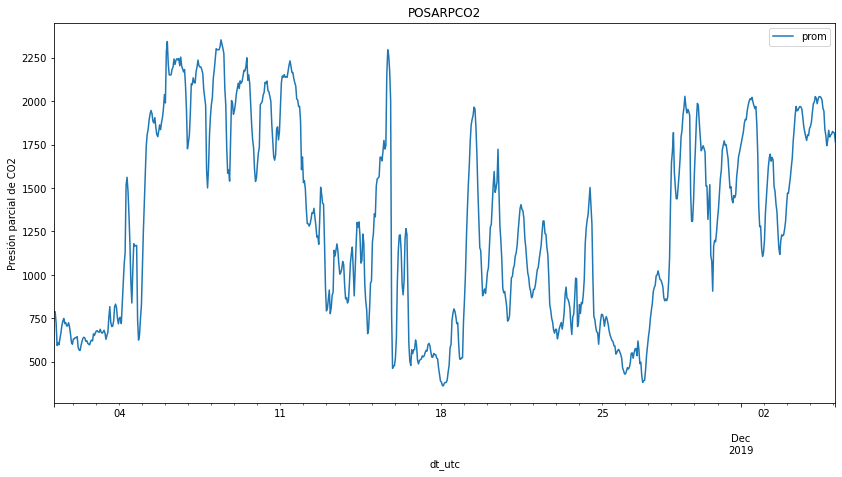

In [19]:
df3.plot(x='dt_utc', y='prom', title=s_cod, figsize=(14,7))
selvar = df2[df2['s_cod'] == s_cod]
# The following line will fail with Python 2.7 and some of the variables, 
# due to special characters like accents
plt.ylabel("{}".format(selvar['tf_nombre'].iloc[0]));